In [49]:
# Config Data Structure
import IPython
import IPython.display

import pandas as pd
import numpy as np
import pprint as pp
import random as ran
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random as ran
import math

from functools import reduce
from collections import Counter
from datetime import datetime as dt
from pymongo import MongoClient as mc
from functools import reduce

sns.set(rc={'figure.figsize': (15.7, 13.27)})
plt.rcParams['figure.figsize'] = 15.7,13.27
plt.rcParams['font.family'] = 'AppleGothic'

mongo_uri = "mongodb://localhost:27017"
client = mc(mongo_uri)
keti_db = client.keti_pattern_recognition

household_col = keti_db.household_info
cluster_col = keti_db.cluster_info
weather_col = keti_db.weather_info

In [50]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='kw (15min)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_subplots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend().remove()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

MAX_EPOCHS = 40

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [51]:
# DB Config
uid = "아파트1-103-1104"

# TimeSlot In
hh_db_datas = household_col.find_one({"uid": uid})
hh_db_datas

hh_datas = pd.DataFrame(columns=['Date Time','kw (15min)'])
timeslot = hh_db_datas['timeslot']

wt_db_datas = weather_col.find()
wt_datas = pd.DataFrame()

hh_datas['kw (15min)'] = [ts['power'] for ts in timeslot]
hh_datas['Date Time'] = [ts['time'] for ts in timeslot]

date_time = pd.to_datetime(hh_datas.pop('Date Time'), format="%Y-%m-%d T%H:%M Z")

hh_datas.index = date_time

timestamp = date_time.map(dt.timestamp)

day = 24*60*60
week = 7*day
year = (365.2425)*day

hh_datas['week sin'] = np.sin(timestamp * (2 * np.pi / week)).values
hh_datas['week cos'] = np.cos(timestamp * (2 * np.pi / week)).values
hh_datas['year sin'] = np.sin(timestamp * (2 * np.pi / year)).values
hh_datas['year cos'] = np.cos(timestamp * (2 * np.pi / year)).values

hh_datas

,kw (15min),week sin,week cos,year sin,year cos
Date Time,,,,,
2018-05-01 00:00:00,0.153,-0.846724,-0.532032,0.880785,-0.473516
2018-05-01 00:15:00,0.146,-0.851662,-0.524092,0.880700,-0.473674
2018-05-01 00:30:00,0.128,-0.856525,-0.516106,0.880615,-0.473832
2018-05-01 00:45:00,0.118,-0.861313,-0.508075,0.880530,-0.473990
2018-05-01 01:00:00,0.119,-0.866025,-0.500000,0.880445,-0.474148
...,...,...,...,...,...
2019-04-30 22:45:00,0.177,-0.958287,0.285808,0.883173,-0.469047
2019-04-30 23:00:00,0.173,-0.955573,0.294755,0.883089,-0.469205
2019-04-30 23:15:00,0.160,-0.952775,0.303677,0.883005,-0.469363


In [52]:
# Split Data Code
split_datas = round(hh_datas[0::4], 3)

split_datas

,kw (15min),week sin,week cos,year sin,year cos
Date Time,,,,,
2018-05-01 00:00:00,0.153,-0.847,-0.532,0.881,-0.474
2018-05-01 01:00:00,0.119,-0.866,-0.500,0.880,-0.474
2018-05-01 02:00:00,0.057,-0.884,-0.467,0.880,-0.475
2018-05-01 03:00:00,0.065,-0.901,-0.434,0.880,-0.475
2018-05-01 04:00:00,0.067,-0.917,-0.400,0.879,-0.476
...,...,...,...,...,...
2019-04-30 19:00:00,0.193,-0.989,0.149,0.884,-0.467
2019-04-30 20:00:00,0.160,-0.983,0.186,0.884,-0.467
2019-04-30 21:00:00,0.177,-0.975,0.223,0.884,-0.468


In [53]:
all_datas_dict = dict()

In [54]:
# Single Step, Univariate, Multivariate Split Logic

# training datas 80%
# validation datas 10%
# validation datas 10%
val_days = []
test_days = []

val_data_percentage = 10
test_data_percentage = 10

# Mon.1 ~ Mon.12
for month in range(1,13):
    val_day_list = []
    test_day_list = []
    day_list = list(set(
        split_datas[split_datas.index.month == month].index.day
    ))
    month_datas = split_datas[split_datas.index.month == month].copy()
    start_day = day_list[0]
    end_day = day_list[len(day_list) - 1] + 1
    
    # 10 percentage split
    val_length = round(len(day_list)) / val_data_percentage
    test_length = round(len(day_list)) / test_data_percentage
    
    while True:
        if (len(val_day_list) >= val_length) and \
            (len (test_day_list) >= test_length):
            break
        while True:
            val_day = ran.randrange(start_day, end_day)
            test_day = ran.randrange(start_day, end_day)

            if (val_day != test_day) and \
                (val_day not in val_day_list + test_day_list) and \
                (test_day not in test_day_list + val_day_list):
                val_days.extend(
                    month_datas[
                        month_datas.index.day == val_day
                    ].index
                )
                test_days.extend(
                    month_datas[
                        month_datas.index.day == test_day
                    ].index
                )
                val_day_list.append(val_day)
                test_day_list.append(test_day)
                break;

train_days = split_datas.drop((val_days + test_days)).index

# Set Univariate Datas
uni_dict = dict()
uni_dict['train'] = pd.DataFrame(split_datas.loc[train_days]['kw (15min)']).copy()
uni_dict['val'] = pd.DataFrame(split_datas.loc[val_days]['kw (15min)']).copy()
uni_dict['test'] = pd.DataFrame(split_datas.loc[test_days]['kw (15min)']).copy()

# Set Multivariate Datas
mul_dict = dict()
mul_dict['train'] = split_datas.loc[train_days].copy()
mul_dict['val'] = split_datas.loc[val_days].copy()
mul_dict['test'] = split_datas.loc[test_days].copy()

In [55]:
# Last Split Split Logic
n = len(split_datas)
train_rate = int(n * 0.8)
val_rate = int(n * 0.9) + 12

last_dict = dict()
last_dict['train'] = pd.DataFrame(split_datas[:train_rate]['kw (15min)']).copy()
last_dict['val'] = pd.DataFrame(split_datas[train_rate: val_rate]['kw (15min)'].copy())
last_dict['test'] = pd.DataFrame(split_datas[val_rate:]['kw (15min)'].copy())

In [56]:
def get_season(month):
    if month in [3,4,5]:
        return "봄"
    elif month in [6,7,8]:
        return "여름"
    elif month in [9,10,11]:
        return "가을"
    else:
        return "겨울"
    
season_train_datas = split_datas.loc[train_days].copy()
season_val_datas = split_datas.loc[val_days].copy()
season_test_datas = split_datas.loc[test_days].copy()
season_train_datas['season'] = [get_season(date.month) for date in season_train_datas.index]
season_val_datas['season'] = [get_season(date.month) for date in season_val_datas.index]
season_test_datas['season'] = [get_season(date.month) for date in season_test_datas.index]

seasons = ['봄', '여름', '가을', '겨울']
seasons_dict = dict()
for season in seasons:
    season_dict = dict()
    
    season_dict['train'] = pd.DataFrame(season_train_datas[
        season_train_datas['season'] == season
    ]['kw (15min)'].copy())
    season_dict['val'] = pd.DataFrame(season_val_datas[
        season_val_datas['season'] == season
    ]['kw (15min)'].copy())
    season_dict['test'] = pd.DataFrame(season_test_datas[
        season_test_datas['season'] == season
    ]['kw (15min)'].copy())
    
    seasons_dict[season] = season_dict

In [57]:
all_dict = dict()

all_dict['univariate'] = uni_dict
all_dict['multivariate'] = mul_dict
all_dict['last'] = last_dict
all_dict['season'] = seasons_dict

In [58]:
norm_all_dict = dict()

for key in all_dict.keys():
    norm_dict = dict()
    ad = all_dict[key]
    
    if key == "season":
        season_dict = dict()
        for season in seasons:
            sd = dict()

            mean = ad[season]['train'].mean()
            std = ad[season]['train'].std()
            sd['train'] = (ad[season]['train'] - mean) / std
            sd['val'] = (ad[season]['val'] - mean) / std
            sd['test'] = (ad[season]['test'] - mean) / std
            
            season_dict[season] = sd
        norm_all_dict[key] = season_dict
    else:
        mean = ad['train'].mean()
        std = ad['train'].std()
        
        norm_dict['train'] = (ad['train'] - mean) / std
        norm_dict['val'] = (ad['val'] - mean) / std
        norm_dict['test'] = (ad['test'] - mean) / std
        
        norm_all_dict[key] = norm_dict

In [62]:
windows = dict()

for key in norm_all_dict.keys():
    nad = norm_all_dict[key]
    
    if key == "season":
        seasons_window = dict()
        for season in seasons:
            season_window = dict()
            for WINDOW_WIDTH in range(3, 21):
                h_key = "{} hours".format(WINDOW_WIDTH)
                season_window[h_key] = WindowGenerator(
                        input_width=WINDOW_WIDTH,
                        label_width=1,
                        shift=1,
                        label_columns=['kw (15min)'],
                        train_df=nad[season]['train'],
                        val_df=nad[season]['val'],
                        test_df=nad[season]['test']
                    )
            seasons_window[season] = season_window
        windows[key] = seasons_window
    else:
        window = dict()
        for WINDOW_WIDTH in range(3, 21):
            h_key = "{} hours".format(WINDOW_WIDTH)
            window[h_key] = WindowGenerator(
                        input_width=WINDOW_WIDTH,
                        label_width=1,
                        shift=1,
                        label_columns=['kw (15min)'],
                        train_df=nad['train'],
                        val_df=nad['val'],
                        test_df=nad['test']
                    )
        windows[key] = window

In [70]:
val_performance = dict()
performance = dict()
models = dict()

for key in windows.keys():
    window = windows[key]
    
    IPython.display.clear_output()
    print("##### {} Training Start #####".format(key))
    if key == 'season':
        seasons_val_perfor = dict()
        seasons_perfor = dict()
        seasons_model = dict()
        for season in seasons:
            print("##### Season is {} #####".format(season))
            season_val_perfor = dict()
            season_perfor = dict()
            season_model = dict()
            for WINDOW_WIDTH in range(3, 21):
                print("##### Hours is {} #####".format(WINDOW_WIDTH))
                h_key = "{} hours".format(WINDOW_WIDTH)
                cur_window = window[season][h_key]
                
                lstm_model = tf.keras.models.Sequential([
                    # Shape [batch, time, features] => [batch, time, lstm_units]
                    tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
                    # Shape => [batch, time, features]
                    tf.keras.layers.Dense(units=1)
                ])
                compile_and_fit(lstm_model, cur_window)
                
                season_val_perfor[h_key] = lstm_model.evaluate(
                    cur_window.val
                )
                
                season_perfor[h_key] = lstm_model.evaluate(
                    cur_window.test
                )
                
                season_model[h_key] = lstm_model
                
            seasons_val_perfor[season] = season_val_perfor
            seasons_perfor[season] = season_perfor
            seasons_model[season] = season_model
        val_performance[key] = seasons_val_perfor
        performance[key] = seasons_perfor
        models[key] = seasons_model
    else:
        val_perfor = dict()
        perfor = dict()
        model = dict()
        
        for WINDOW_WIDTH in range(3,21):
            print("##### Hours is {} #####".format(WINDOW_WIDTH))
            h_key = "{} hours".format(WINDOW_WIDTH)
            cur_window = window[h_key]

            lstm_model = tf.keras.models.Sequential([
                # Shape [batch, time, features] => [batch, time, lstm_units]
                tf.keras.layers.LSTM(64, return_sequences=True, activation="tanh"),
                # Shape => [batch, time, features]
                tf.keras.layers.Dense(units=1)
            ])
            compile_and_fit(lstm_model, cur_window)

            val_perfor[h_key] = lstm_model.evaluate(
                cur_window.val
            )

            perfor[h_key] = lstm_model.evaluate(
                cur_window.test
            )

            model[h_key] = lstm_model
            
        val_performance[key] = val_perfor
        performance[key] = perfor
        models[key] = model

##### season Training Start #####
##### Season is 봄 #####
##### Hours is 3 #####
Epoch 1/40
53/53 [==============================] - 2s 8ms/step - loss: 0.8952 - mean_absolute_error: 0.6848 - val_loss: 0.6594 - val_mean_absolute_error: 0.5643
Epoch 2/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8663 - mean_absolute_error: 0.6716 - val_loss: 0.6553 - val_mean_absolute_error: 0.5626
Epoch 3/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8556 - mean_absolute_error: 0.6654 - val_loss: 0.6527 - val_mean_absolute_error: 0.5595
Epoch 4/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8497 - mean_absolute_error: 0.6612 - val_loss: 0.6521 - val_mean_absolute_error: 0.5578
Epoch 5/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8467 - mean_absolute_error: 0.6587 - val_loss: 0.6520 - val_mean_absolute_error: 0.5571
Epoch 6/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8449 - mean_absolute_error: 0.6571 

53/53 [==============================] - 0s 3ms/step - loss: 0.8951 - mean_absolute_error: 0.6864 - val_loss: 0.6795 - val_mean_absolute_error: 0.5764
Epoch 10/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8941 - mean_absolute_error: 0.6857 - val_loss: 0.6790 - val_mean_absolute_error: 0.5760
Epoch 11/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8929 - mean_absolute_error: 0.6848 - val_loss: 0.6784 - val_mean_absolute_error: 0.5755
Epoch 12/40
53/53 [==============================] - 0s 4ms/step - loss: 0.8914 - mean_absolute_error: 0.6836 - val_loss: 0.6774 - val_mean_absolute_error: 0.5747
Epoch 13/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8893 - mean_absolute_error: 0.6821 - val_loss: 0.6760 - val_mean_absolute_error: 0.5738
Epoch 14/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8869 - mean_absolute_error: 0.6804 - val_loss: 0.6742 - val_mean_absolute_error: 0.5727
Epoch 15/40
53/53 [===============

53/53 [==============================] - 0s 4ms/step - loss: 0.8992 - mean_absolute_error: 0.6868 - val_loss: 0.6733 - val_mean_absolute_error: 0.5730
Epoch 22/40
53/53 [==============================] - 0s 4ms/step - loss: 0.8986 - mean_absolute_error: 0.6863 - val_loss: 0.6732 - val_mean_absolute_error: 0.5731
Epoch 23/40
53/53 [==============================] - 0s 4ms/step - loss: 0.8980 - mean_absolute_error: 0.6859 - val_loss: 0.6732 - val_mean_absolute_error: 0.5732
Epoch 24/40
53/53 [==============================] - 0s 4ms/step - loss: 0.8975 - mean_absolute_error: 0.6856 - val_loss: 0.6732 - val_mean_absolute_error: 0.5733
Epoch 25/40
53/53 [==============================] - 0s 4ms/step - loss: 0.8971 - mean_absolute_error: 0.6853 - val_loss: 0.6732 - val_mean_absolute_error: 0.5734
Epoch 26/40
9/9 [==============================] - 0s 1ms/step - loss: 0.7764 - mean_absolute_error: 0.6828
##### Hours is 6 #####
Epoch 1/40
53/53 [==============================] - 2s 9ms/step - 

8/8 [==============================] - 0s 2ms/step - loss: 0.8479 - mean_absolute_error: 0.7258
##### Hours is 15 #####
Epoch 1/40
53/53 [==============================] - 2s 10ms/step - loss: 1.0212 - mean_absolute_error: 0.7523 - val_loss: 0.7221 - val_mean_absolute_error: 0.6000
Epoch 2/40
53/53 [==============================] - 0s 5ms/step - loss: 1.0015 - mean_absolute_error: 0.7462 - val_loss: 0.7242 - val_mean_absolute_error: 0.6030
Epoch 3/40
8/8 [==============================] - 0s 2ms/step - loss: 0.8492 - mean_absolute_error: 0.7265
##### Hours is 16 #####
Epoch 1/40
52/52 [==============================] - 2s 11ms/step - loss: 1.0118 - mean_absolute_error: 0.7481 - val_loss: 0.7192 - val_mean_absolute_error: 0.5970
Epoch 2/40
52/52 [==============================] - 0s 6ms/step - loss: 1.0015 - mean_absolute_error: 0.7446 - val_loss: 0.7208 - val_mean_absolute_error: 0.5988
Epoch 3/40
8/8 [==============================] - 0s 2ms/step - loss: 0.8465 - mean_absolute_error:

53/53 [==============================] - 0s 3ms/step - loss: 0.8511 - mean_absolute_error: 0.5511 - val_loss: 1.4559 - val_mean_absolute_error: 0.7478
Epoch 25/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8510 - mean_absolute_error: 0.5511 - val_loss: 1.4556 - val_mean_absolute_error: 0.7480
Epoch 26/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8508 - mean_absolute_error: 0.5510 - val_loss: 1.4552 - val_mean_absolute_error: 0.7481
Epoch 27/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8506 - mean_absolute_error: 0.5510 - val_loss: 1.4547 - val_mean_absolute_error: 0.7483
Epoch 28/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8504 - mean_absolute_error: 0.5509 - val_loss: 1.4541 - val_mean_absolute_error: 0.7485
Epoch 29/40
53/53 [==============================] - 0s 3ms/step - loss: 0.8502 - mean_absolute_error: 0.5508 - val_loss: 1.4534 - val_mean_absolute_error: 0.7488
Epoch 30/40
53/53 [===============

53/53 [==============================] - 2s 9ms/step - loss: 0.9660 - mean_absolute_error: 0.5839 - val_loss: 1.5718 - val_mean_absolute_error: 0.7873
Epoch 2/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9284 - mean_absolute_error: 0.5876 - val_loss: 1.5526 - val_mean_absolute_error: 0.7959
Epoch 3/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9254 - mean_absolute_error: 0.5907 - val_loss: 1.5463 - val_mean_absolute_error: 0.7954
Epoch 4/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9224 - mean_absolute_error: 0.5903 - val_loss: 1.5428 - val_mean_absolute_error: 0.7947
Epoch 5/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9204 - mean_absolute_error: 0.5900 - val_loss: 1.5404 - val_mean_absolute_error: 0.7940
Epoch 6/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9190 - mean_absolute_error: 0.5897 - val_loss: 1.5387 - val_mean_absolute_error: 0.7935
Epoch 7/40
53/53 [=====================

53/53 [==============================] - 0s 4ms/step - loss: 0.9242 - mean_absolute_error: 0.5938 - val_loss: 1.5806 - val_mean_absolute_error: 0.8072
Epoch 12/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9238 - mean_absolute_error: 0.5938 - val_loss: 1.5800 - val_mean_absolute_error: 0.8071
Epoch 13/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9234 - mean_absolute_error: 0.5938 - val_loss: 1.5793 - val_mean_absolute_error: 0.8070
Epoch 14/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9231 - mean_absolute_error: 0.5938 - val_loss: 1.5787 - val_mean_absolute_error: 0.8070
Epoch 15/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9228 - mean_absolute_error: 0.5938 - val_loss: 1.5781 - val_mean_absolute_error: 0.8069
Epoch 16/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9225 - mean_absolute_error: 0.5938 - val_loss: 1.5775 - val_mean_absolute_error: 0.8069
Epoch 17/40
53/53 [===============

53/53 [==============================] - 0s 4ms/step - loss: 0.9269 - mean_absolute_error: 0.5970 - val_loss: 1.6169 - val_mean_absolute_error: 0.8238
Epoch 23/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9265 - mean_absolute_error: 0.5970 - val_loss: 1.6158 - val_mean_absolute_error: 0.8244
Epoch 24/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9259 - mean_absolute_error: 0.5969 - val_loss: 1.6147 - val_mean_absolute_error: 0.8251
Epoch 25/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9253 - mean_absolute_error: 0.5968 - val_loss: 1.6135 - val_mean_absolute_error: 0.8261
Epoch 26/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9247 - mean_absolute_error: 0.5968 - val_loss: 1.6123 - val_mean_absolute_error: 0.8270
Epoch 27/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9239 - mean_absolute_error: 0.5965 - val_loss: 1.6114 - val_mean_absolute_error: 0.8283
Epoch 28/40
53/53 [===============

53/53 [==============================] - 0s 4ms/step - loss: 0.9267 - mean_absolute_error: 0.5967 - val_loss: 1.6523 - val_mean_absolute_error: 0.8414
Epoch 35/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9253 - mean_absolute_error: 0.5960 - val_loss: 1.6506 - val_mean_absolute_error: 0.8429
Epoch 36/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9251 - mean_absolute_error: 0.5958 - val_loss: 1.6508 - val_mean_absolute_error: 0.8430
Epoch 37/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9239 - mean_absolute_error: 0.5953 - val_loss: 1.6498 - val_mean_absolute_error: 0.8438
Epoch 38/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9235 - mean_absolute_error: 0.5951 - val_loss: 1.6501 - val_mean_absolute_error: 0.8442
Epoch 39/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9225 - mean_absolute_error: 0.5946 - val_loss: 1.6495 - val_mean_absolute_error: 0.8446
Epoch 40/40
8/8 [=================

Epoch 15/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9444 - mean_absolute_error: 0.6056 - val_loss: 1.6792 - val_mean_absolute_error: 0.8444
Epoch 16/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9435 - mean_absolute_error: 0.6053 - val_loss: 1.6769 - val_mean_absolute_error: 0.8443
Epoch 17/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9436 - mean_absolute_error: 0.6056 - val_loss: 1.6777 - val_mean_absolute_error: 0.8446
Epoch 18/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9424 - mean_absolute_error: 0.6053 - val_loss: 1.6752 - val_mean_absolute_error: 0.8443
Epoch 19/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9423 - mean_absolute_error: 0.6054 - val_loss: 1.6751 - val_mean_absolute_error: 0.8444
Epoch 20/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9413 - mean_absolute_error: 0.6049 - val_loss: 1.6726 - val_mean_absolute_error: 0.8445
Epoch 21/40
53/53 [===

Epoch 27/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9439 - mean_absolute_error: 0.6055 - val_loss: 1.6829 - val_mean_absolute_error: 0.8507
Epoch 28/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9464 - mean_absolute_error: 0.6082 - val_loss: 1.6890 - val_mean_absolute_error: 0.8493
Epoch 29/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9425 - mean_absolute_error: 0.6053 - val_loss: 1.6794 - val_mean_absolute_error: 0.8496
Epoch 30/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9448 - mean_absolute_error: 0.6073 - val_loss: 1.6850 - val_mean_absolute_error: 0.8493
Epoch 31/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9415 - mean_absolute_error: 0.6049 - val_loss: 1.6767 - val_mean_absolute_error: 0.8490
Epoch 32/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9434 - mean_absolute_error: 0.6060 - val_loss: 1.6813 - val_mean_absolute_error: 0.8490
Epoch 33/40
53/53 [===

Epoch 36/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9458 - mean_absolute_error: 0.6081 - val_loss: 1.7068 - val_mean_absolute_error: 0.8590
Epoch 37/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9444 - mean_absolute_error: 0.6072 - val_loss: 1.7044 - val_mean_absolute_error: 0.8582
Epoch 38/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9448 - mean_absolute_error: 0.6074 - val_loss: 1.7062 - val_mean_absolute_error: 0.8591
Epoch 39/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9437 - mean_absolute_error: 0.6068 - val_loss: 1.7043 - val_mean_absolute_error: 0.8578
Epoch 40/40
8/8 [==============================] - 0s 2ms/step - loss: 1.6132 - mean_absolute_error: 0.8061
##### Hours is 14 #####
Epoch 1/40
53/53 [==============================] - 2s 10ms/step - loss: 0.9816 - mean_absolute_error: 0.5926 - val_loss: 1.7636 - val_mean_absolute_error: 0.8565
Epoch 2/40
53/53 [==============================] - 0

Epoch 4/40
8/8 [==============================] - 0s 2ms/step - loss: 1.6220 - mean_absolute_error: 0.8129
##### Hours is 16 #####
Epoch 1/40
52/52 [==============================] - 2s 11ms/step - loss: 0.9758 - mean_absolute_error: 0.5895 - val_loss: 1.7827 - val_mean_absolute_error: 0.8668
Epoch 2/40
52/52 [==============================] - 0s 6ms/step - loss: 0.9664 - mean_absolute_error: 0.6116 - val_loss: 1.7750 - val_mean_absolute_error: 0.8678
Epoch 3/40
52/52 [==============================] - 0s 6ms/step - loss: 0.9645 - mean_absolute_error: 0.6117 - val_loss: 1.7773 - val_mean_absolute_error: 0.8712
Epoch 4/40
8/8 [==============================] - 0s 2ms/step - loss: 1.6353 - mean_absolute_error: 0.8120
##### Hours is 17 #####
Epoch 1/40
52/52 [==============================] - 2s 13ms/step - loss: 0.9935 - mean_absolute_error: 0.5960 - val_loss: 1.7958 - val_mean_absolute_error: 0.8635
Epoch 2/40
52/52 [==============================] - 0s 6ms/step - loss: 0.9713 - mean_ab

8/8 [==============================] - 0s 3ms/step - loss: 1.6687 - mean_absolute_error: 0.8190
##### Hours is 20 #####
Epoch 1/40
52/52 [==============================] - 2s 11ms/step - loss: 0.9860 - mean_absolute_error: 0.5934 - val_loss: 1.8386 - val_mean_absolute_error: 0.8977
Epoch 2/40
52/52 [==============================] - 0s 6ms/step - loss: 0.9683 - mean_absolute_error: 0.6138 - val_loss: 1.8282 - val_mean_absolute_error: 0.8959
Epoch 3/40
52/52 [==============================] - 0s 6ms/step - loss: 0.9628 - mean_absolute_error: 0.6147 - val_loss: 1.8306 - val_mean_absolute_error: 0.8995
Epoch 4/40
52/52 [==============================] - 0s 6ms/step - loss: 0.9598 - mean_absolute_error: 0.6141 - val_loss: 1.8228 - val_mean_absolute_error: 0.9008
Epoch 5/40
52/52 [==============================] - 0s 7ms/step - loss: 0.9592 - mean_absolute_error: 0.6167 - val_loss: 1.8276 - val_mean_absolute_error: 0.9046
Epoch 6/40
8/8 [==============================] - 0s 2ms/step - loss:

8/8 [==============================] - 0s 1ms/step - loss: 1.2619 - mean_absolute_error: 0.8412
##### Hours is 4 #####
Epoch 1/40
54/54 [==============================] - 2s 8ms/step - loss: 0.9699 - mean_absolute_error: 0.7697 - val_loss: 1.4653 - val_mean_absolute_error: 0.9117
Epoch 2/40
54/54 [==============================] - 0s 3ms/step - loss: 0.9177 - mean_absolute_error: 0.7438 - val_loss: 1.4248 - val_mean_absolute_error: 0.9007
Epoch 3/40
54/54 [==============================] - 0s 3ms/step - loss: 0.9053 - mean_absolute_error: 0.7380 - val_loss: 1.4064 - val_mean_absolute_error: 0.8934
Epoch 4/40
54/54 [==============================] - 0s 3ms/step - loss: 0.8979 - mean_absolute_error: 0.7335 - val_loss: 1.3966 - val_mean_absolute_error: 0.8884
Epoch 5/40
54/54 [==============================] - 0s 4ms/step - loss: 0.8938 - mean_absolute_error: 0.7306 - val_loss: 1.3911 - val_mean_absolute_error: 0.8851
Epoch 6/40
54/54 [==============================] - 0s 3ms/step - loss:

54/54 [==============================] - 0s 4ms/step - loss: 0.9163 - mean_absolute_error: 0.7435 - val_loss: 1.4333 - val_mean_absolute_error: 0.9082
Epoch 10/40
54/54 [==============================] - 0s 4ms/step - loss: 0.9154 - mean_absolute_error: 0.7428 - val_loss: 1.4323 - val_mean_absolute_error: 0.9077
Epoch 11/40
54/54 [==============================] - 0s 4ms/step - loss: 0.9147 - mean_absolute_error: 0.7423 - val_loss: 1.4315 - val_mean_absolute_error: 0.9072
Epoch 12/40
54/54 [==============================] - 0s 4ms/step - loss: 0.9140 - mean_absolute_error: 0.7418 - val_loss: 1.4306 - val_mean_absolute_error: 0.9067
Epoch 13/40
54/54 [==============================] - 0s 4ms/step - loss: 0.9134 - mean_absolute_error: 0.7414 - val_loss: 1.4297 - val_mean_absolute_error: 0.9063
Epoch 14/40
54/54 [==============================] - 0s 4ms/step - loss: 0.9128 - mean_absolute_error: 0.7409 - val_loss: 1.4287 - val_mean_absolute_error: 0.9058
Epoch 15/40
54/54 [===============

54/54 [==============================] - 0s 4ms/step - loss: 0.9289 - mean_absolute_error: 0.7512 - val_loss: 1.4543 - val_mean_absolute_error: 0.9198
Epoch 19/40
54/54 [==============================] - 0s 4ms/step - loss: 0.9279 - mean_absolute_error: 0.7507 - val_loss: 1.4531 - val_mean_absolute_error: 0.9191
Epoch 20/40
54/54 [==============================] - 0s 4ms/step - loss: 0.9269 - mean_absolute_error: 0.7500 - val_loss: 1.4520 - val_mean_absolute_error: 0.9184
Epoch 21/40
54/54 [==============================] - 0s 4ms/step - loss: 0.9258 - mean_absolute_error: 0.7494 - val_loss: 1.4509 - val_mean_absolute_error: 0.9175
Epoch 22/40
54/54 [==============================] - 0s 5ms/step - loss: 0.9245 - mean_absolute_error: 0.7488 - val_loss: 1.4498 - val_mean_absolute_error: 0.9167
Epoch 23/40
54/54 [==============================] - 0s 4ms/step - loss: 0.9233 - mean_absolute_error: 0.7481 - val_loss: 1.4489 - val_mean_absolute_error: 0.9159
Epoch 24/40
54/54 [===============

Epoch 10/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9560 - mean_absolute_error: 0.7651 - val_loss: 1.5016 - val_mean_absolute_error: 0.9389
Epoch 11/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9555 - mean_absolute_error: 0.7648 - val_loss: 1.5013 - val_mean_absolute_error: 0.9387
Epoch 12/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9550 - mean_absolute_error: 0.7646 - val_loss: 1.5011 - val_mean_absolute_error: 0.9385
Epoch 13/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9546 - mean_absolute_error: 0.7643 - val_loss: 1.5009 - val_mean_absolute_error: 0.9383
Epoch 14/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9543 - mean_absolute_error: 0.7641 - val_loss: 1.5008 - val_mean_absolute_error: 0.9382
Epoch 15/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9539 - mean_absolute_error: 0.7639 - val_loss: 1.5007 - val_mean_absolute_error: 0.9381
Epoch 16/40
53/53 [===

Epoch 19/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9572 - mean_absolute_error: 0.7662 - val_loss: 1.5095 - val_mean_absolute_error: 0.9359
Epoch 20/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9568 - mean_absolute_error: 0.7660 - val_loss: 1.5090 - val_mean_absolute_error: 0.9358
Epoch 21/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9566 - mean_absolute_error: 0.7658 - val_loss: 1.5086 - val_mean_absolute_error: 0.9357
Epoch 22/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9562 - mean_absolute_error: 0.7656 - val_loss: 1.5079 - val_mean_absolute_error: 0.9357
Epoch 23/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9558 - mean_absolute_error: 0.7654 - val_loss: 1.5074 - val_mean_absolute_error: 0.9357
Epoch 24/40
53/53 [==============================] - 0s 4ms/step - loss: 0.9553 - mean_absolute_error: 0.7651 - val_loss: 1.5065 - val_mean_absolute_error: 0.9357
Epoch 25/40
53/53 [===

Epoch 12/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9667 - mean_absolute_error: 0.7720 - val_loss: 1.5284 - val_mean_absolute_error: 0.9380
Epoch 13/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9663 - mean_absolute_error: 0.7717 - val_loss: 1.5281 - val_mean_absolute_error: 0.9378
Epoch 14/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9659 - mean_absolute_error: 0.7715 - val_loss: 1.5279 - val_mean_absolute_error: 0.9376
Epoch 15/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9655 - mean_absolute_error: 0.7713 - val_loss: 1.5277 - val_mean_absolute_error: 0.9375
Epoch 16/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9652 - mean_absolute_error: 0.7711 - val_loss: 1.5277 - val_mean_absolute_error: 0.9374
Epoch 17/40
53/53 [==============================] - 0s 5ms/step - loss: 0.9648 - mean_absolute_error: 0.7710 - val_loss: 1.5276 - val_mean_absolute_error: 0.9374
Epoch 18/40
53/53 [===

53/53 [==============================] - 0s 6ms/step - loss: 0.9774 - mean_absolute_error: 0.7766 - val_loss: 1.5529 - val_mean_absolute_error: 0.9503
Epoch 9/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9768 - mean_absolute_error: 0.7763 - val_loss: 1.5526 - val_mean_absolute_error: 0.9502
Epoch 10/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9762 - mean_absolute_error: 0.7759 - val_loss: 1.5523 - val_mean_absolute_error: 0.9501
Epoch 11/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9758 - mean_absolute_error: 0.7758 - val_loss: 1.5522 - val_mean_absolute_error: 0.9500
Epoch 12/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9752 - mean_absolute_error: 0.7755 - val_loss: 1.5521 - val_mean_absolute_error: 0.9501
Epoch 13/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9748 - mean_absolute_error: 0.7753 - val_loss: 1.5521 - val_mean_absolute_error: 0.9500
Epoch 14/40
8/8 [==================

Epoch 11/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9826 - mean_absolute_error: 0.7803 - val_loss: 1.5462 - val_mean_absolute_error: 0.9506
Epoch 12/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9822 - mean_absolute_error: 0.7800 - val_loss: 1.5457 - val_mean_absolute_error: 0.9505
Epoch 13/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9819 - mean_absolute_error: 0.7798 - val_loss: 1.5454 - val_mean_absolute_error: 0.9504
Epoch 14/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9814 - mean_absolute_error: 0.7797 - val_loss: 1.5452 - val_mean_absolute_error: 0.9503
Epoch 15/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9810 - mean_absolute_error: 0.7794 - val_loss: 1.5450 - val_mean_absolute_error: 0.9502
Epoch 16/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9806 - mean_absolute_error: 0.7792 - val_loss: 1.5449 - val_mean_absolute_error: 0.9502
Epoch 17/40
53/53 [===

Epoch 14/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9839 - mean_absolute_error: 0.7815 - val_loss: 1.5523 - val_mean_absolute_error: 0.9525
Epoch 15/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9834 - mean_absolute_error: 0.7812 - val_loss: 1.5520 - val_mean_absolute_error: 0.9524
Epoch 16/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9829 - mean_absolute_error: 0.7808 - val_loss: 1.5522 - val_mean_absolute_error: 0.9525
Epoch 17/40
7/7 [==============================] - 0s 2ms/step - loss: 1.6098 - mean_absolute_error: 0.9698
##### Hours is 19 #####
Epoch 1/40
53/53 [==============================] - 2s 11ms/step - loss: 0.9695 - mean_absolute_error: 0.7797 - val_loss: 1.5721 - val_mean_absolute_error: 0.9547
Epoch 2/40
53/53 [==============================] - 0s 6ms/step - loss: 0.9542 - mean_absolute_error: 0.7788 - val_loss: 1.5601 - val_mean_absolute_error: 0.9557
Epoch 3/40
53/53 [==============================] - 0s

51/51 [==============================] - 0s 3ms/step - loss: 0.7657 - mean_absolute_error: 0.6624 - val_loss: 0.7305 - val_mean_absolute_error: 0.6791
Epoch 9/40
51/51 [==============================] - 0s 3ms/step - loss: 0.7643 - mean_absolute_error: 0.6610 - val_loss: 0.7293 - val_mean_absolute_error: 0.6778
Epoch 10/40
51/51 [==============================] - 0s 3ms/step - loss: 0.7633 - mean_absolute_error: 0.6599 - val_loss: 0.7284 - val_mean_absolute_error: 0.6768
Epoch 11/40
51/51 [==============================] - 0s 3ms/step - loss: 0.7625 - mean_absolute_error: 0.6590 - val_loss: 0.7277 - val_mean_absolute_error: 0.6760
Epoch 12/40
51/51 [==============================] - 0s 3ms/step - loss: 0.7617 - mean_absolute_error: 0.6583 - val_loss: 0.7270 - val_mean_absolute_error: 0.6753
Epoch 13/40
51/51 [==============================] - 0s 3ms/step - loss: 0.7611 - mean_absolute_error: 0.6576 - val_loss: 0.7264 - val_mean_absolute_error: 0.6747
Epoch 14/40
51/51 [================

51/51 [==============================] - 0s 4ms/step - loss: 0.8040 - mean_absolute_error: 0.6838 - val_loss: 0.7782 - val_mean_absolute_error: 0.7002
Epoch 18/40
51/51 [==============================] - 0s 3ms/step - loss: 0.8020 - mean_absolute_error: 0.6826 - val_loss: 0.7772 - val_mean_absolute_error: 0.6990
Epoch 19/40
51/51 [==============================] - 0s 3ms/step - loss: 0.8001 - mean_absolute_error: 0.6817 - val_loss: 0.7764 - val_mean_absolute_error: 0.6980
Epoch 20/40
51/51 [==============================] - 0s 3ms/step - loss: 0.7984 - mean_absolute_error: 0.6809 - val_loss: 0.7759 - val_mean_absolute_error: 0.6972
Epoch 21/40
51/51 [==============================] - 0s 4ms/step - loss: 0.7968 - mean_absolute_error: 0.6803 - val_loss: 0.7756 - val_mean_absolute_error: 0.6964
Epoch 22/40
51/51 [==============================] - 0s 4ms/step - loss: 0.7956 - mean_absolute_error: 0.6798 - val_loss: 0.7753 - val_mean_absolute_error: 0.6958
Epoch 23/40
51/51 [===============

Epoch 5/40
9/9 [==============================] - 0s 1ms/step - loss: 0.8834 - mean_absolute_error: 0.7065
##### Hours is 7 #####
Epoch 1/40
51/51 [==============================] - 2s 9ms/step - loss: 0.9634 - mean_absolute_error: 0.7793 - val_loss: 0.9196 - val_mean_absolute_error: 0.7767
Epoch 2/40
51/51 [==============================] - 0s 4ms/step - loss: 0.9312 - mean_absolute_error: 0.7634 - val_loss: 0.9183 - val_mean_absolute_error: 0.7733
Epoch 3/40
51/51 [==============================] - 0s 4ms/step - loss: 0.9185 - mean_absolute_error: 0.7549 - val_loss: 0.9191 - val_mean_absolute_error: 0.7711
Epoch 4/40
9/9 [==============================] - 0s 2ms/step - loss: 0.8914 - mean_absolute_error: 0.7119
##### Hours is 8 #####
Epoch 1/40
51/51 [==============================] - 2s 9ms/step - loss: 0.9777 - mean_absolute_error: 0.7843 - val_loss: 0.9381 - val_mean_absolute_error: 0.7810
Epoch 2/40
51/51 [==============================] - 0s 5ms/step - loss: 0.9452 - mean_absolu

8/8 [==============================] - 0s 2ms/step - loss: 0.9099 - mean_absolute_error: 0.7204
##### Hours is 17 #####
Epoch 1/40
51/51 [==============================] - 2s 11ms/step - loss: 1.0289 - mean_absolute_error: 0.8023 - val_loss: 1.0099 - val_mean_absolute_error: 0.7909
Epoch 2/40
51/51 [==============================] - 0s 6ms/step - loss: 0.9638 - mean_absolute_error: 0.7739 - val_loss: 1.0192 - val_mean_absolute_error: 0.7928
Epoch 3/40
8/8 [==============================] - 0s 2ms/step - loss: 0.9066 - mean_absolute_error: 0.7178
##### Hours is 18 #####
Epoch 1/40
51/51 [==============================] - 2s 11ms/step - loss: 1.0342 - mean_absolute_error: 0.8035 - val_loss: 1.0214 - val_mean_absolute_error: 0.7952
Epoch 2/40
51/51 [==============================] - 0s 6ms/step - loss: 0.9735 - mean_absolute_error: 0.7792 - val_loss: 1.0336 - val_mean_absolute_error: 0.7979
Epoch 3/40
8/8 [==============================] - 0s 2ms/step - loss: 0.9103 - mean_absolute_error:

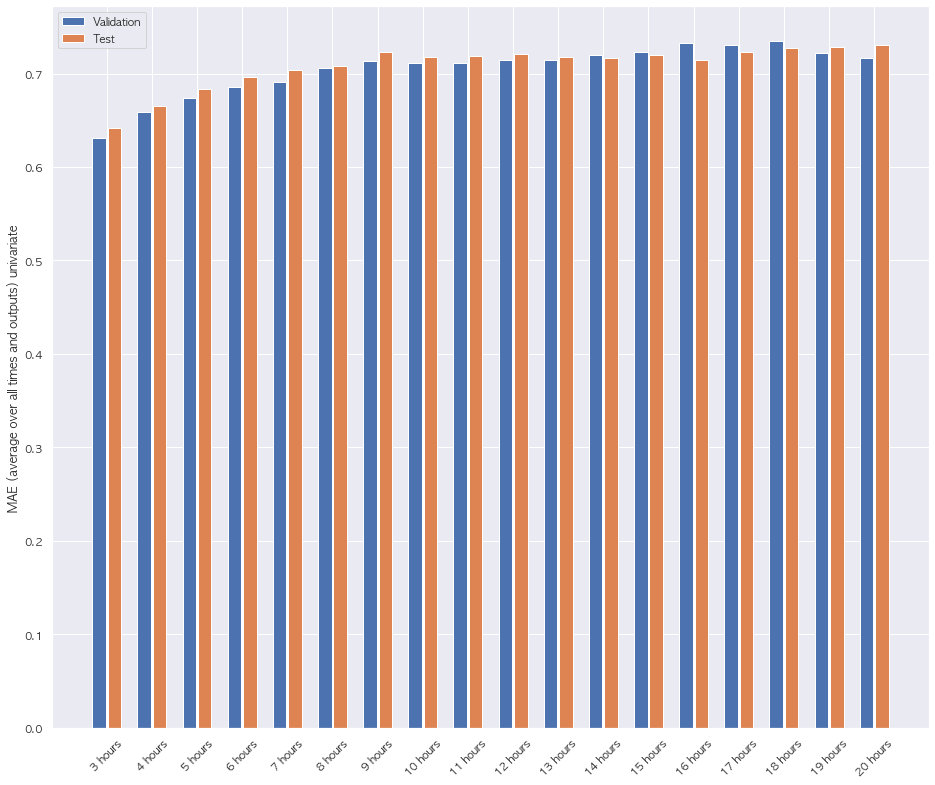

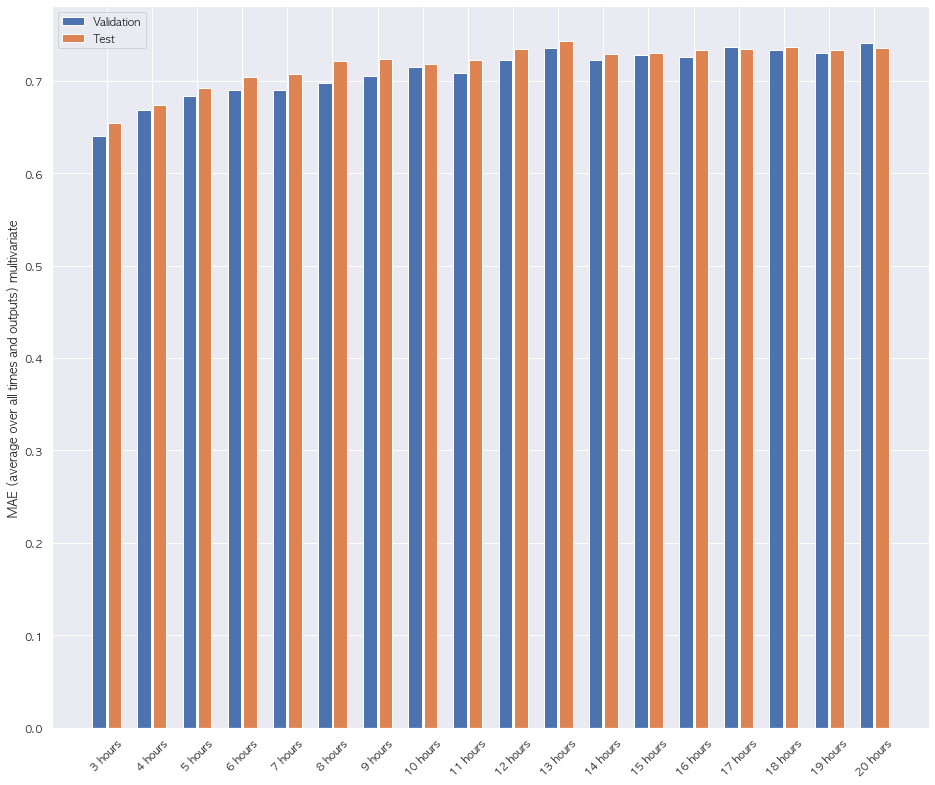

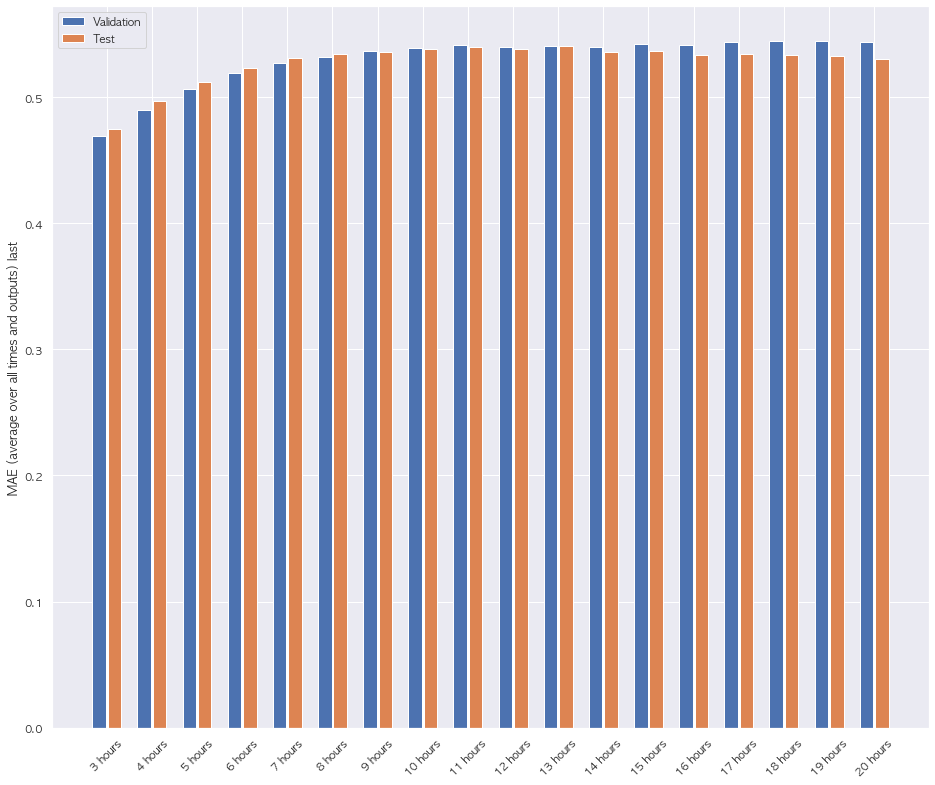

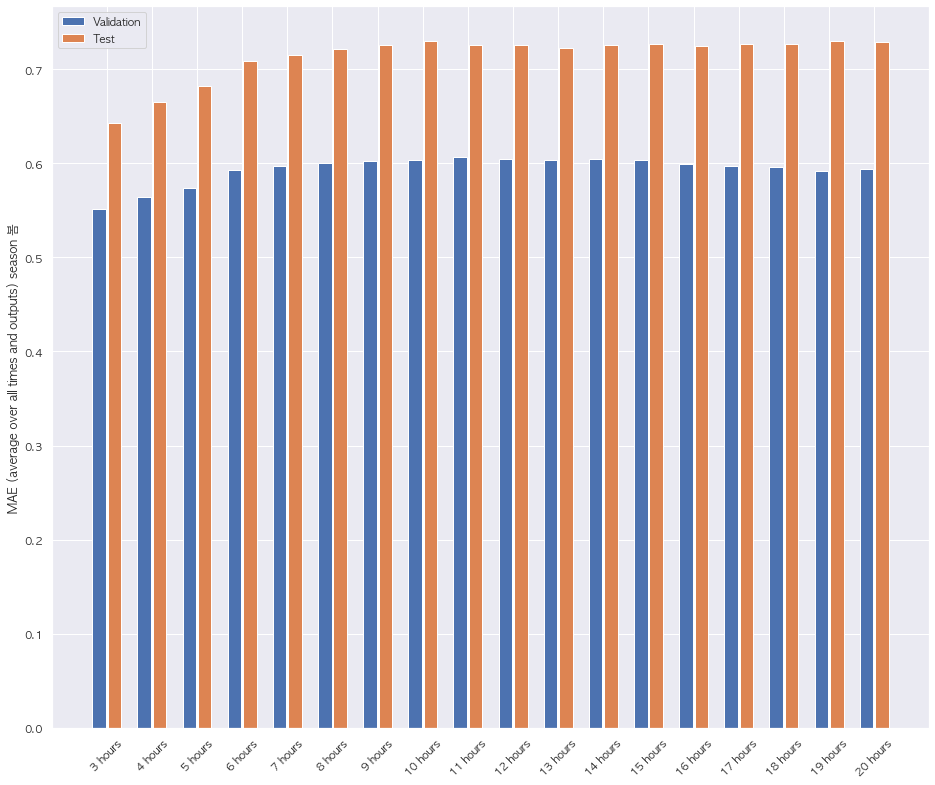

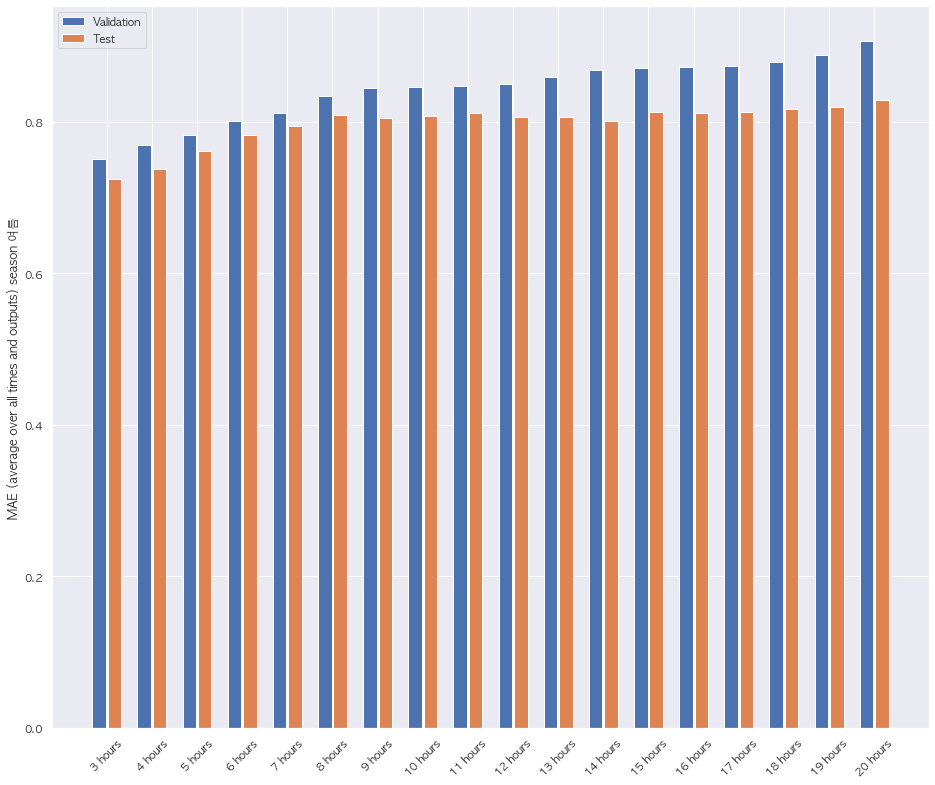

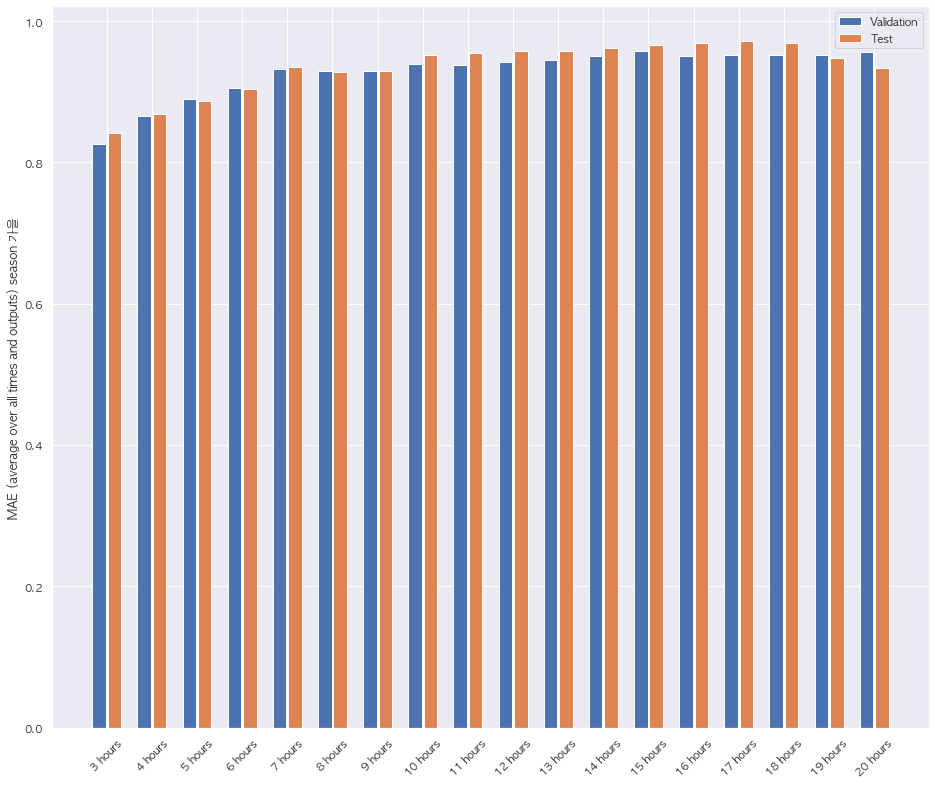

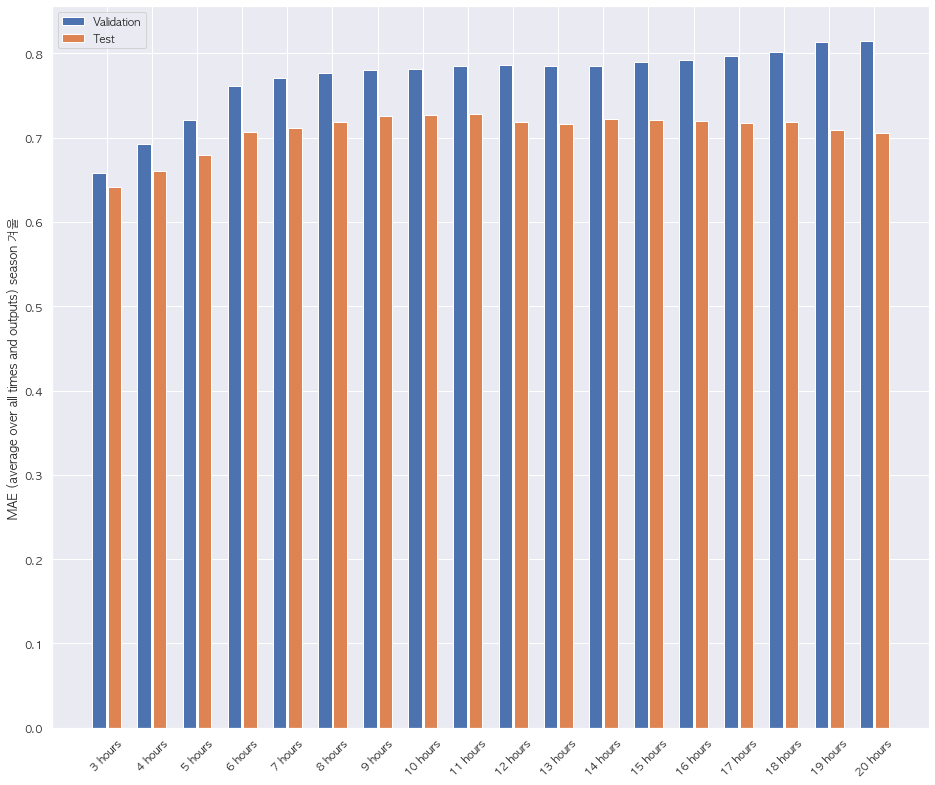

In [85]:
for key in performance.keys():
    cur_val_performance = val_performance[key]
    cur_performance = performance[key]
    
    if key == "season":
        for season in seasons:
            cur_val_performance = val_performance[key][season]
            cur_performance = performance[key][season]
            
            x = np.arange(len(cur_performance))
            width = 0.3

            metric_name = 'mean_absolute_error'
            metric_index = lstm_model.metrics_names.index('mean_absolute_error')
            val_mae = [v[metric_index] for v in cur_val_performance.values()]
            test_mae = [v[metric_index] for v in cur_performance.values()]

            plt.bar(x - 0.17, val_mae, width, label='Validation')
            plt.bar(x + 0.17, test_mae, width, label='Test')
            plt.xticks(ticks=x, labels=cur_performance.keys(),
                       rotation=45)
            plt.ylabel(f'MAE (average over all times and outputs) {key} {season}')
            _ = plt.legend()
            plt.show()
    else:
        x = np.arange(len(cur_performance))
        width = 0.3

        metric_name = 'mean_absolute_error'
        metric_index = lstm_model.metrics_names.index('mean_absolute_error')
        val_mae = [v[metric_index] for v in cur_val_performance.values()]
        test_mae = [v[metric_index] for v in cur_performance.values()]

        plt.bar(x - 0.17, val_mae, width, label='Validation')
        plt.bar(x + 0.17, test_mae, width, label='Test')
        plt.xticks(ticks=x, labels=cur_performance.keys(),
                   rotation=45)
        plt.ylabel(f'MAE (average over all times and outputs) {key}')
        _ = plt.legend()
        plt.show()